### Subtomogram Alignment and Averaging

In [1]:
import numpy as np
import torch
import scipy
import mrcfile
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

volumes = '/Users/HenryJones/Desktop/volume.mrc'
coordinates = '/Users/HenryJones/Desktop/SULI/ribo_coordinates.txt'
volume = torch.tensor(mrcfile.read(volumes))
#coordinates are output centered in nm before magnification
coords = torch.Tensor(np.genfromtxt(coordinates, skip_header = 2))


In [3]:
print(volume.shape)

torch.Size([200, 1000, 1000])


## Rotation based on Euler Angles
from 
https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/transforms/rotation_conversions.html#euler_angles_to_matrix


In [4]:
#make our rotation matrix
def angles_to_matrix(angles: torch.Tensor)-> torch.Tensor:
    assert angles.shape[0] == 3
    phi   = angles[0] * torch.pi / 180
    theta = angles[1] * torch.pi / 180
    psi   = angles[2] * torch.pi / 180
    
    sinphi = torch.sin(phi)
    cosphi = torch.cos(phi)
    
    sintheta = torch.sin(theta)
    costheta = torch.cos(theta)
    
    sinpsi = torch.sin(psi)
    cospsi = torch.cos(psi)
    
    r_mat = torch.Tensor([[cospsi * cosphi - (sinpsi * costheta * sinphi), 
                            - (cospsi * sinphi) - (sinpsi * costheta * cosphi),
                            sinpsi * sintheta],
                           [(sinpsi * cosphi) + (cospsi * costheta * sinphi),
                            -(sinpsi * sinphi) + (cospsi * costheta * cosphi),
                            - (cospsi * sintheta)],
                           [sintheta * sinphi, sintheta * cosphi, costheta]])
    return r_mat

In [13]:
def check_transpose(in_tensor: torch.Tensor, correct_shape: torch.Size):
    if in_tensor.shape != correct_shape:
        return torch.transpose(in_tensor, 0, 1)
    return in_tensor


def pick_particles(coords: torch.Tensor):
    #fits in in the detector
    first_mask = coords[((torch.abs(coords[:,0]) + ribosome_diameter) * factor <= correct_size[2]/2) \
                        & ((torch.abs(coords[:,1]) + ribosome_diameter) * factor <= correct_size[1]/2)\
                       & ((torch.abs(coords[:,2]) + ribosome_radius) * factor <= correct_size[0]/2)] #radius for the z axis
    #volume specific modification
    #print(first_mask.dtype)
    #second_mask = coords[first_mask]
    second = first_mask[torch.sqrt(first_mask[:,0] **2 + first_mask[:,1] **2) < 600 -  ribosome_diameter]
    #first_mask = coords[((torch.abs(coords[:,0]) + ribosome_diameter) * factor <= correct_size[1]/2) \
    #                    & ((torch.abs(coords[:,1]) + ribosome_diameter) * factor <= correct_size[2]/2)]
    upper_distance_matrix = torch.triu(torch.cdist(second[:,:3], second[:,:3], p=2) > ribosome_diameter)
    final_mask = ((upper_distance_matrix + torch.transpose(upper_distance_matrix, 0, 1)).sum(dim = 0) == upper_distance_matrix.shape[0]-1)
    coords = second[final_mask]
    return coords

def new_extract_subtomos(volume: torch.Tensor, picked_coordinates: torch.Tensor):
    tensor_of_subtomos = np.empty(shape = int(picked_coordinates.shape[0]), dtype = object)
    tensor_of_coords = torch.empty(size = (int(picked_coordinates.shape[0]),3))
    #tensor_of_pixel_coords
    for particle in range(int(picked_coordinates.shape[0])):
        pixel_coord_float = torch.Tensor([picked_coordinates[particle,0] * factor + volume.shape[-1]/2,
                                          picked_coordinates[particle,1] * factor + volume.shape[-2]/2,
                                          picked_coordinates[particle,2] * 1 + volume.shape[-3]/2]) #reverse the order of the z axis
                                          #picked_coordinates[particle,2] * z_factor + volume.shape[-3]/2])
                                         #volume.shape[-3] - (picked_coordinates[particle,2] * z_factor + volume.shape[-3]/2)]) #reverse the order of the z axis
        pixel_coord = torch.round(pixel_coord_float).int()
        tensor_of_coords[particle] = pixel_coord_float
        bounds = torch.Tensor([ [pixel_coord[2] - ribo_pixel_radius,   pixel_coord[2] + ribo_pixel_radius],
                                [pixel_coord[1] - ribo_pixel_diameter, pixel_coord[1] + ribo_pixel_diameter],
                                [pixel_coord[0] - ribo_pixel_diameter, pixel_coord[0] + ribo_pixel_diameter]]).int()

        below = torch.tensor(torch.where(bounds < 0, 1, 0))

        above = torch.tensor(torch.where(bounds > torch.stack([torch.tensor(volume.shape),
                                                  torch.tensor(volume.shape)]).T, 1, 0))
        old_bounds = torch.abs(bounds * (below + above)) # element wise multiplication of EITHER mask, but will always be one or the other
        
        #for slicing we need to adjust
        bounds[(bounds < 0)] = 0
        bounds[0,1][bounds[0,1] > volume.shape[0]] = volume.shape[0]
        
        #extract subtomo
        tensor_of_subtomos[particle] = volume[int(bounds[0,0]) : int(bounds[0,1]) + 1,
                                              int(bounds[1,0]) : int(bounds[1,1]) + 1,
                                              int(bounds[2,0]) : int(bounds[2,1]) + 1]
        
        #pad z dimension if particle is within particle radius of volume face.
        tensor_of_subtomos[particle] = torch.nn.functional.pad(tensor_of_subtomos[particle],
                                                               (0,0,0,0, # by our selection we don't need x and y padding
                                                                old_bounds[0,0], #low z padding
                                                                old_bounds[0,1]), #high z padding
                                                               mode = 'constant')
    return tensor_of_subtomos, tensor_of_coords

def new_meshgrid(subtomo_shape: torch.Size, particle_center: torch.Tensor) -> torch.meshgrid:
    """
        should only have to worry about not being centered with z axis
        Example of particle center is 
        
        torch.Tensor([1809.6265, 1761.0503,   54.2631])
    """

    center_diff = particle_center - torch.round(particle_center)

    x = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[2]) + center_diff[0]
    y = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[1]) + center_diff[1]
    z = torch.linspace(start = - ribo_pixel_diameter, end = ribo_pixel_diameter, steps = subtomo_shape[0]) + center_diff[2]
    
    return torch.meshgrid(x, y, z, indexing = 'ij'), x, y, z


def align_and_average(new_out, picked_coords, new_pixel_coords, ribo_pixel_radius):

    #loop over subtomograms, picked particle rotation angles, and updated interger pixel coordinates
    for subtomo, angles, pixel_coord in zip(new_out, picked_coords[:,-3:], new_pixel_coords[:,:3]):
        average_size = ribo_pixel_radius * 2 +1
        average = torch.zeros((average_size, average_size, average_size))
        rmat = angles_to_matrix(angles)
        #need to invert because the rotations have been applied to give the current orientation
        inverse_rmat = torch.linalg.inv(rmat)
        padded = torch.nn.functional.pad(subtomo, (0,0,0,0, ribo_pixel_radius, ribo_pixel_radius), mode = 'constant', value = 0)
        meshgrid, x_linspace, y_linspace, z_linspace = new_meshgrid(padded.shape, pixel_coord) #picked_part[:3])
        x = torch.flatten(meshgrid[0])
        y = torch.flatten(meshgrid[1])
        z = torch.flatten(meshgrid[2])
        before_rotation = torch.stack([x, y, z])
        rotation = torch.matmul(inverse_rmat, torch.stack([z,y, x])) # was z,y,x before nov 8

        #center_diff = pixel_coord - torch.round(pixel_coord)

        in_grid_shape = torch.unflatten(rotation, dim = 1, sizes = (padded.shape[0],
                                                        padded.shape[1],
                                                        padded.shape[2]))[:,
                                                                            int(padded.shape[0]/2 - ribo_pixel_radius):  int(padded.shape[0]/2 + ribo_pixel_radius) + 1, 
                                                                            int(padded.shape[1]/2 - ribo_pixel_radius):  int(padded.shape[1]/2 + ribo_pixel_radius) + 1,
                                                                            int(padded.shape[2]/2 - ribo_pixel_radius):  int(padded.shape[2]/2 + ribo_pixel_radius) + 1]
        data_w_coords = scipy.interpolate.RegularGridInterpolator((z_linspace.numpy(), y_linspace.numpy(), x_linspace.numpy()), padded.numpy())

        #apply spherical mask, does it matter before or after interpolation and rotation?
        mask = torch.where(torch.sqrt(in_grid_shape[0]**2 + in_grid_shape[1]**2 + in_grid_shape[2]**2) < ribo_pixel_radius, 1, 0)
        #print(mask.shape, 'MASK SHAPE')
        
        interpolation = data_w_coords((in_grid_shape[0].numpy(),
                                    in_grid_shape[1].numpy(),
                                        in_grid_shape[2].numpy()))
        
        average = average + interpolation[:, :, :] * mask.numpy()
    average /= new_out.shape[0]
    return average


"""
ARGS and inputs

"""
#80S ribosomes have diameters up to 300-320 A which is 30-32 nm
#We know our tem simulator uses magnification 
#750000 with detector size 16000 nm
magnification = 75000
detector_size_nm = 16000
ribosome_radius = 15 # nm
#factor = magnification / detector_size_nm /2
#for now, with volume
factor = 1
ribosome_diameter = 2 * ribosome_radius
ribo_pixel_radius = int(torch.round(torch.Tensor([factor * ribosome_radius])))
ribo_pixel_diameter = 2 * ribo_pixel_radius
print(ribo_pixel_radius, 'pixel_radius')
print(ribosome_diameter + ribosome_radius, 'neighbor distance')
correct_size = torch.Size([200, 1000, 1000]) #z, y, x

#we only need to crop in the x and y planes
def main():
    picked_coords = pick_particles(coords)
    subtomos, new_pixel_coords = new_extract_subtomos(volume, picked_coords)
    print("Number of subtomograms:", subtomos.shape[0])
    return align_and_average(subtomos, picked_coords = picked_coords, new_pixel_coords=new_pixel_coords, ribo_pixel_radius= ribo_pixel_radius)

average = main()

15 pixel_radius
45 neighbor distance
Number of subtomograms: 122


/var/folders/gr/_q7_46ws0hl7qy90fpjmx3tw0000gq/T/ipykernel_15994/1577800699.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  below = torch.tensor(torch.where(bounds < 0, 1, 0))
/var/folders/gr/_q7_46ws0hl7qy90fpjmx3tw0000gq/T/ipykernel_15994/1577800699.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  above = torch.tensor(torch.where(bounds > torch.stack([torch.tensor(volume.shape),


## Image space alignment and averaging

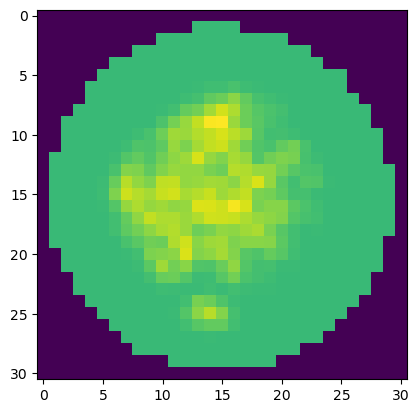

In [11]:
plt.imshow(average[11,:,:])

In [12]:
mrc = mrcfile.new("checking.mrc")
mrc.set_data(average.numpy().astype(np.float32))
mrc.close()

## Now try at rotating the meshgrids